## Imports

In [1]:
import math
import random
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import IPython

In [2]:
!pip install chess


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import chess
import chess.svg

## Loading training data

In [4]:
!ls -lh drive/MyDrive/Data/training_data.zip

ls: cannot access 'drive/MyDrive/Data/training_data.zip': No such file or directory


In [5]:
!cp drive/MyDrive/Data/training_data.zip training_data.zip

cp: cannot stat 'drive/MyDrive/Data/training_data.zip': No such file or directory


In [6]:
! [ ! -f training_data.bin ] && unzip training_data.zip

unzip:  cannot find or open training_data.zip, training_data.zip.zip or training_data.zip.ZIP.


In [7]:
!ls -lh training_data.bin

ls: cannot access 'training_data.bin': No such file or directory


### training data format definition

In [8]:
K_INPUT, K_ACTIONS = 7 * 8 * 8, 64 * 64
DT = np.dtype(
    [
        ("board_tensor", np.float32, (K_INPUT,)),
        ("legal_mask", np.bool, (K_ACTIONS,)),
        ("policy", np.float32, (K_ACTIONS,)),
        ("child_visit_counts", np.int32, (K_ACTIONS,)),
        ("child_values", np.float32, (K_ACTIONS,)),
        ("value", np.float32),
        ("final_value", np.int32),
    ]
)

In [9]:
class TrainingDataset(Dataset):
    def __init__(self, filename):
        self.records = np.fromfile(filename, dtype=DT)

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec = self.records[idx]
        board_tensor = torch.from_numpy(rec["board_tensor"]).float().reshape(7, 8, 8)
        legal_mask = torch.from_numpy(rec["legal_mask"]).bool()
        policy = torch.from_numpy(rec["policy"]).float()
        child_visit_counts = torch.from_numpy(rec["child_visit_counts"]).int()
        child_values = torch.from_numpy(rec["child_values"]).float()
        value = torch.tensor(rec["value"], dtype=torch.float32)
        final_value = torch.tensor(rec["final_value"], dtype=torch.int32)
        return {
            "board_tensor": board_tensor,
            "policy": policy,
            "legal_mask": legal_mask,
            "child_visit_counts": child_visit_counts,
            "child_values": child_values,
            "value": value,
            "final_value": final_value,
        }

### load from file

In [10]:
dataset = TrainingDataset('/home/krkartikay/code/min-alpha-zero/training_data.bin')

In [11]:
print(len(dataset))

9562


## Inspect some data

In [12]:
print(len(dataset))
for record in dataset:
    print(record.keys())
    print(record['board_tensor'].shape)
    print(record['policy'].shape)
    print(record['legal_mask'].shape)
    print(record['child_visit_counts'].shape)
    print(record['child_values'].shape)
    print(record['value'].shape)
    print(record['final_value'].shape)
    break

9562
dict_keys(['board_tensor', 'policy', 'legal_mask', 'child_visit_counts', 'child_values', 'value', 'final_value'])
torch.Size([7, 8, 8])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([])
torch.Size([])


## Chess Library and Utils

In [13]:
#@title util function definitions
def tensor_to_board(board_tensor):
    """Convert 7x8x8 tensor back to chess board"""
    board = chess.Board(fen=None)
    board.clear()

    piece_types = [
        chess.PAWN,
        chess.KNIGHT,
        chess.BISHOP,
        chess.ROOK,
        chess.QUEEN,
        chess.KING,
    ]

    # Decode pieces
    for channel in range(6):
        for rank in range(8):
            for file in range(8):
                value = board_tensor[channel, rank, file].item()
                if value != 0:
                    square = chess.square(file, rank)
                    piece_type = piece_types[channel]
                    color = chess.WHITE if value > 0 else chess.BLACK
                    piece = chess.Piece(piece_type, color)
                    board.set_piece_at(square, piece)

    # Set turn
    turn_value = board_tensor[6, 0, 0].item()
    board.turn = chess.WHITE if turn_value > 0 else chess.BLACK

    return board


def action_to_san(action, board):
    """Convert action index to SAN notation"""
    try:
        from_sq = action // 64
        to_sq = action % 64
        from_square = chess.Square(from_sq)
        to_square = chess.Square(to_sq)

        # Try to create a move
        move = chess.Move(from_square, to_square)

        # Check for promotions
        piece = board.piece_at(from_square)
        if piece and piece.piece_type == chess.PAWN:
            if (piece.color == chess.WHITE and to_sq >= 56) or (
                piece.color == chess.BLACK and to_sq <= 7
            ):
                move = chess.Move(from_square, to_square, promotion=chess.QUEEN)

        # Check if move is legal
        if move in board.legal_moves:
            return board.san(move)
        else:
            # Try different promotions
            for promotion in [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT]:
                move = chess.Move(from_square, to_square, promotion=promotion)
                if move in board.legal_moves:
                    return board.san(move)

            # If still not legal, return algebraic notation
            return chess.square_name(from_sq) + chess.square_name(to_sq)
    except:
        return f"action{action}"

def board_to_tensor(board):
    """Convert chess board to tensor format matching chess_utils.hpp"""
    tensor = np.zeros((7, 8, 8), dtype=np.float32)

    # Convert piece positions
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            file = chess.square_file(square)
            rank = chess.square_rank(square)
            piece_type = piece.piece_type - 1  # 0-based indexing
            color = 1.0 if piece.color == chess.WHITE else -1.0
            tensor[piece_type, rank, file] = color

    # Add turn channel (channel 6)
    turn_value = 1.0 if board.turn == chess.WHITE else -1.0
    tensor[6, :, :] = turn_value

    return tensor


def move_to_int(move):
    """Convert move to integer format matching chess_utils.hpp"""
    return move.from_square * 64 + move.to_square


def index_to_coordinates(i):
    """Map policy index to coordinates in the 64x64 grid."""
    from_sq = i // 64
    to_sq = i % 64
    x_big = from_sq // 8
    y_big = from_sq % 8
    x_small = to_sq // 8
    y_small = to_sq % 8
    x_all = x_big * 8 + x_small
    y_all = y_big * 8 + y_small
    return x_all, y_all

## Visualizing Training data

In [14]:
#@title visualization helpers
def plot_move_heatmap(array_4096, title="Move Heatmap", filename=None):
    arr = np.zeros((64, 64), dtype=np.float32)
    for idx, val in enumerate(array_4096):
        x, y = index_to_coordinates(idx)
        arr[x, y] = val
    plt.figure(figsize=(5, 5))
    plt.imshow(arr, origin="lower")
    plt.colorbar(label="Value")
    plt.xlabel("To Square (0–63)")
    plt.ylabel("From Square (0–63)")
    plt.title(title)
    plt.show()

def plot_moves(array_4096, board=None, max_arrows=20):
    assert len(array_4096) == 4096
    if board is None:
        board = chess.Board()
    array_4096 = np.asarray(array_4096)

    # Get indices of top-N values (by absolute value for visualization)
    if max_arrows is not None:
        top_indices = np.argsort(np.abs(array_4096))[::-1][:max_arrows]
    else:
        top_indices = np.arange(4096)

    arrows = []
    vals = array_4096[top_indices]
    vmin, vmax = np.min(vals), np.max(vals)
    val_range = vmax - vmin if vmax != vmin else 1.0

    for idx, val in zip(top_indices, vals):
        from_sq = idx // 64
        to_sq = idx % 64
        # Normalize opacity to [0, 1]
        opacity = abs(val) / max(vmax, vmin) if val_range > 0 else 1.0
        # Use a color scale (blue for positive, red for negative)
        if val >= 0:
            rgba = f'rgba(30, 90, 230, {opacity:.2f})'
        else:
            rgba = f'rgba(220, 30, 30, {opacity:.2f})'
        arrows.append(chess.svg.Arrow(from_sq, to_sq, color=rgba))

    return IPython.display.HTML(chess.svg.board(board, arrows=arrows, size=400))

3363


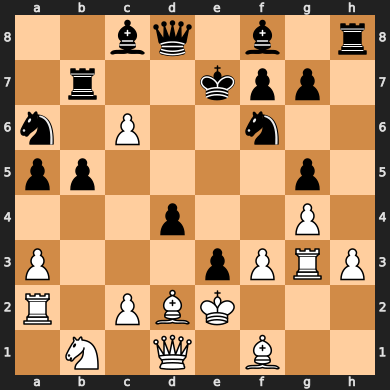

In [15]:
idx = random.randint(0, len(dataset))
print(idx)
tensor_to_board(dataset[idx]['board_tensor'])

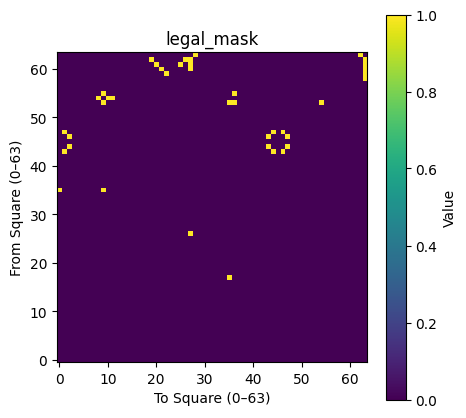

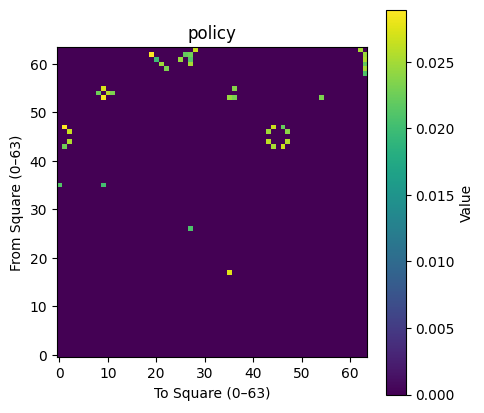

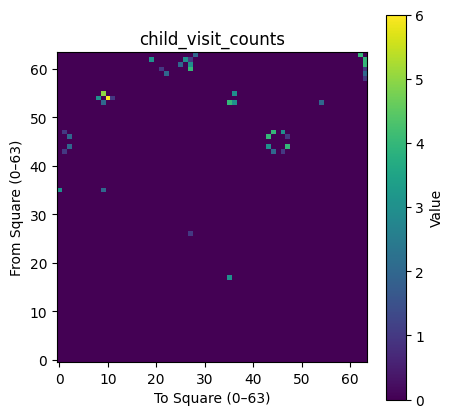

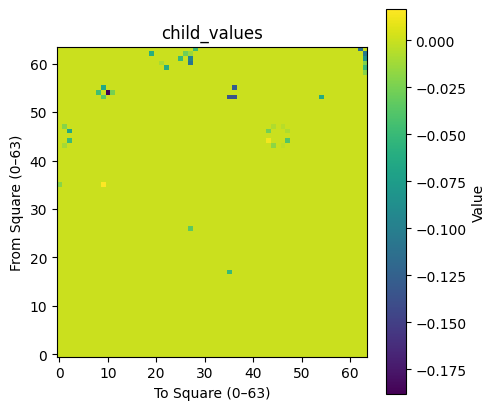

In [16]:
plot_move_heatmap(dataset[idx]['legal_mask'], title="legal_mask")
plot_move_heatmap(dataset[idx]['policy'], title="policy")
plot_move_heatmap(dataset[idx]['child_visit_counts'], title="child_visit_counts")
plot_move_heatmap(dataset[idx]['child_values'], title="child_values")

## Define a small CNN model and try training it

### Define model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(  7, 64, 3, padding=1)
        self.flat = nn.Flatten()
        self.policy_head = nn.Linear(64*8*8, 4096)  # For move distribution (64x64)
        self.value_head = nn.Linear(64*8*8, 1)      # For scalar value

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.flat(x)
        policy = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        return policy, value

    def predict(self, x, legal_mask):
        policy_logits, value = self.forward(x)
        # Set illegal logits to -1e10 before softmax
        masked_logits = policy_logits.masked_fill(~legal_mask.bool(), -1e10)
        probs = F.softmax(masked_logits, dim=1)
        return probs, value  # (batch, 4096), (batch,)

### Training Loop

In [19]:
model = Model().to(device)
x = dataset[0]['board_tensor'].unsqueeze(0)  # (1, 7, 8, 8)
y1, y2 = model(x.to(device))

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f"Trainable parameters: {total_params / 10**6:5.1f}M")

Model(
  (conv0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (policy_head): Linear(in_features=4096, out_features=4096, bias=True)
  (value_head): Linear(in_features=4096, out_features=1, bias=True)
)
Trainable parameters:  16.8M


In [20]:
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [22]:
#@title intrinsic entropy of target distribution
import torch
import torch.nn.functional as F

H_q_history = []

for batch in dataloader:
    y1 = batch['child_visit_counts'].float().to(device)  # (B, 4096)
    target_policy = y1 / (y1.sum(dim=1, keepdim=True) + 1e-6)

    # H(q) = -∑ q log q
    H_q = -(target_policy * target_policy.clamp(min=1e-12).log()).sum(dim=1).mean()

    H_q_history.append(H_q.item() * y1.shape[0])

print("Average H(q):", sum(H_q_history)/len(dataset))

Average H(q): 3.129103941339949


In [23]:
#@title training loop
use_legal_mask = True
loss_history = []
epochs = 100
for e in range(epochs):
  total_loss = torch.tensor(0.).to(device)
  for i, batch in enumerate(dataloader):
    x = batch['board_tensor'].to(device)                    # (B, 7, 8, 8)
    y1 = batch['child_visit_counts'].float().to(device)     # (B, 4096)
    y2 = batch['final_value'].float().to(device)            # (B,)
    legal_mask = batch['legal_mask'].to(device)             # (B, 4096), 0/1 or bool

    policy_logits, value_pred = model(x) # (B, 4096), (B,)
    if use_legal_mask:
      policy_logits *= legal_mask

    value_loss = F.mse_loss(value_pred, y2)

    target_policy = y1 / (y1.sum(dim=1, keepdim=True)  + 1e-6)

    log_probs = F.log_softmax(policy_logits, dim=1)

    log_target_policy = target_policy.clamp(min=1e-12).log()
    policy_loss = (target_policy * (log_target_policy - log_probs)).sum(dim=1).mean()

    loss = value_loss + policy_loss
    total_loss += loss * x.shape[0]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  total_loss /= len(dataset)
  loss_history.append(total_loss.item())
  if (e+1) % 10 == 0:
    print(f"Epoch {e+1} Loss: {total_loss.item():.4f}")

Epoch 10 Loss: 0.2589
Epoch 20 Loss: 0.2138
Epoch 30 Loss: 0.1846
Epoch 40 Loss: 0.1599
Epoch 50 Loss: 0.1430
Epoch 60 Loss: 0.1277
Epoch 70 Loss: 0.1187
Epoch 80 Loss: 0.1072
Epoch 90 Loss: 0.1013
Epoch 100 Loss: 0.0920


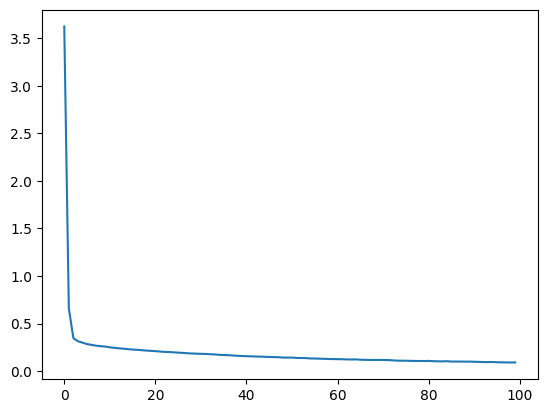

In [24]:
plt.plot(loss_history)

In [25]:
idx = random.randint(0, len(dataset))
print(idx)

7266


In [26]:
x = dataset[idx]['board_tensor'].to(device).unsqueeze(0)

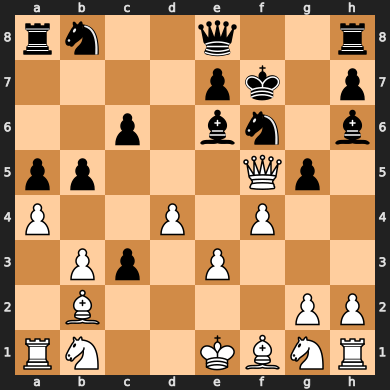

In [27]:
tensor_to_board(x[0])

In [28]:
import ipywidgets as widgets

out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()

# Put them side by side
box = widgets.HBox([out1, out2, out3, out4])
display(box)

with out1:
  p, v = model(x)
  plot_move_heatmap(p.cpu().detach().numpy()[0], title="policy logits")
with out2:
  p, v = model(x)
  plot_move_heatmap(F.softmax(p, dim=1).cpu().detach().numpy()[0], title="policy probs")
with out3:
  p, v = model.predict(x, dataset[idx]['legal_mask'].to(device))
  plot_move_heatmap(p.cpu().detach().numpy()[0], title="policy probs masked")
with out4:
  plot_move_heatmap(dataset[idx]['child_visit_counts'])

### Visualize weights and activations

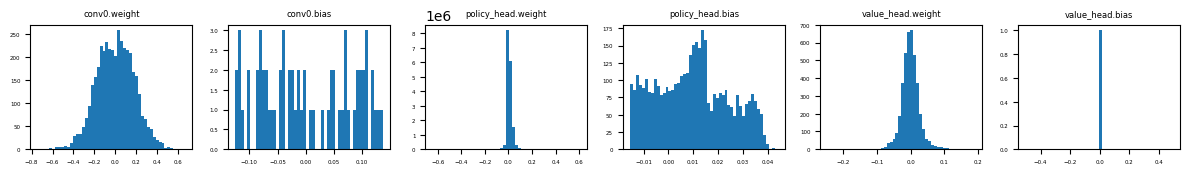

In [29]:
params = [(n, p.data.cpu().numpy().ravel())
          for n, p in model.named_parameters() if 'weight' in n or 'bias' in n]

rows, cols = math.ceil(len(params)/6), 6
fig, axes = plt.subplots(rows, cols, figsize=(12, 2*rows))
for ax, (n, d) in zip(axes.ravel(), params):
    ax.hist(d, bins=50)
    ax.set_title(n, fontsize=6)
    ax.tick_params(labelsize=4)
for ax in axes.ravel()[len(params):]:
    ax.axis('off')
plt.tight_layout(); plt.show()

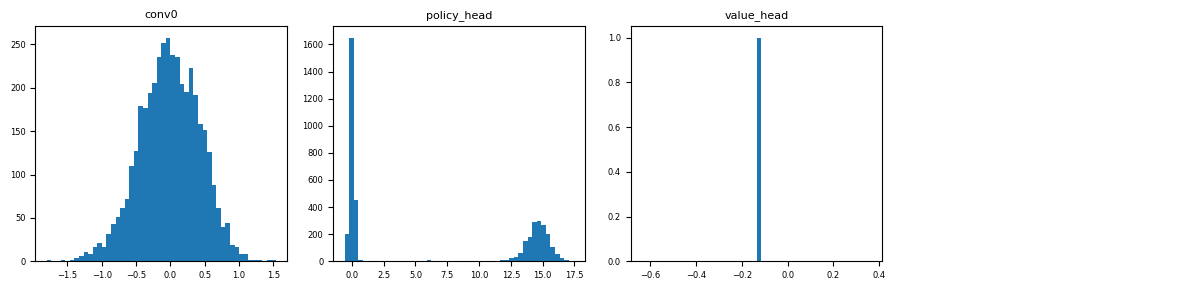

In [30]:
# Dict to store activations
activations = {}

def save_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu().numpy().ravel()
    return hook

# Register hooks
for name, module in model.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        module.register_forward_hook(save_activation(name))

# Run a forward pass once with a sample input
p, v = model.predict(x, dataset[idx]['legal_mask'].to(device))

# Plot histograms
rows, cols = math.ceil(len(activations)/4), 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
for ax, (n, d) in zip(axes.ravel(), activations.items()):
    ax.hist(d, bins=50)
    ax.set_title(n, fontsize=8)
    ax.tick_params(labelsize=6)
for ax in axes.ravel()[len(activations):]:
    ax.axis('off')
plt.tight_layout(); plt.show()